In [1]:
import sys
print(sys.version)
print(sys.path)

3.7.9 (default, Jan  8 2021, 17:41:21) 
[GCC 7.5.0]
['/home/tokudo/Develop/grips/unicorn/notebooks', '/home/tokudo/.pyenv/versions/3.7.9/lib/python37.zip', '/home/tokudo/.pyenv/versions/3.7.9/lib/python3.7', '/home/tokudo/.pyenv/versions/3.7.9/lib/python3.7/lib-dynload', '', '/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages', '/home/tokudo/Develop/grips/grina', '/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages/IPython/extensions', '/home/tokudo/.ipython']


In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
fpath = os.path.join("..", "data", "unicorn_company_invester.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

df["Valuation($B) flaot"] = df["Valuation($B)"].apply(trans2float)

In [5]:
df["Valuation($B) flaot"].describe()

count    501.000000
mean       3.185749
std        7.676841
min        1.000000
25%        1.000000
50%        1.500000
75%        3.000000
max      140.000000
Name: Valuation($B) flaot, dtype: float64

In [6]:
df["DateTime Joined"] = df["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [7]:
df.head()

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.0,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.0,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.5,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.0,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.0,2015-10-12


In [8]:
def clean(element):
    return element.strip()

In [9]:
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Didi Chuxing
Bitmain Technologies
Grab
Tokopedia


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,100credit,Sequoia Capital China
1,100credit,China Reform Fund
2,100credit,Hillhouse Capital Management
3,17zuoye,DST Global
4,17zuoye,Temasek Holdings
...,...,...
1380,Zwift,True
1381,Zwift,Causeway Media Partners
1382,Zymergen,Data Collective
1383,Zymergen,True Ventures


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]



# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation($B),Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
1,China Reform Fund,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
2,Hillhouse Capital Management,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
3,DST Global,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07
4,Temasek Holdings,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Industry": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                Country  \
                                    sum count  mean <lambda_0>   
0       01 Advisors                2.00     1  2.00          1   
1      500 Startups                4.50     2  2.25          2   
2            58.com                3.00     2  1.50          1   
3        5Y Capital                1.22     1  1.22          1   
4           83North               11.55     5  2.31          3   
..              ...                 ...   ...   ...        ...   
690         iFLYTEK                1.00     1  1.00          1   
691  iNovia Capital                1.04     1  1.04          1   
692   iTech Capital                1.00     1  1.00          1   
693  index Ventures                5.50     1  5.50          1   
694          next47                1.60     1  1.60          1   

                                        Industry  \
                                  set <lambda_0>   
0                     {United States}          1   
1            {Indonesia, Philippines}          2   
2                             {China}          1   
3                             {China}          1   
4    {Germany, France, United States}          4   
..                                ...        ...   
690                           {China}          1   
691                   {United States}          1   
692                     {Netherlands}          1   
693                  {United Kingdom}          1   
694                   {United States}          1   

                                                          Company  \
                                                   set <lambda_0>   
0                                            {Fintech}          1   
1             {E-commerce & direct-to-consumer, Other}          2   
2                    {E-commerce & direct-to-consumer}          2   
3                        {Mobile & telecommunications}          1   
4    {Auto & transportation, E-commerce & direct-to...          5   
..                                                 ...        ...   
690                                         {Hardware}          1   
691                  {E-commerce & direct-to-consumer}          1   
692                                         {Hardware}          1   
693                                          {Fintech}          1   
694                                    {Cybersecurity}          1   

                                                       DateTime Joined  
                                                   set             min  
0                                            {Tipalti}      2020-10-06  
1                   {Revolution Precrafted, Bukalapak}      2017-10-23  
2                            {Tubatu.com, Zhuan Zhuan}      2015-03-09  
3                                        {GalaxySpace}      2020-11-17  
4    {Payoneer, Marqeta, Mirakl, Via Transportation...      2017-12-05  
..                                                 ...             ...  
690                              {TERMINUS Technology}      2018-10-25  
691                                        {AppDirect}      2015-10-07  
692                                          {BitFury}      2018-11-06  
693                                          {Revolut}      2018-04-26  
694                                          {Verkada}      2020-01-29  

[695 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,01 Advisors,2.00,1,2.00,1,{United States},1,{Fintech},1,{Tipalti},2020-10-06
1,500 Startups,4.50,2,2.25,2,"{Indonesia, Philippines}",2,"{E-commerce & direct-to-consumer, Other}",2,"{Revolution Precrafted, Bukalapak}",2017-10-23
2,58.com,3.00,2,1.50,1,{China},1,{E-commerce & direct-to-consumer},2,"{Tubatu.com, Zhuan Zhuan}",2015-03-09
3,5Y Capital,1.22,1,1.22,1,{China},1,{Mobile & telecommunications},1,{GalaxySpace},2020-11-17
4,83North,11.55,5,2.31,3,"{Germany, France, United States}",4,"{Auto & transportation, E-commerce & direct-to...",5,"{Payoneer, Marqeta, Mirakl, Via Transportation...",2017-12-05


In [23]:
analysis_invest_df.to_csv(os.path.join("..", "out", "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,JOY Capital,0.002882,0.000000,2.050078e-03,0.160678,0.000807,1.50,1,1.500000,1,{China},1,{Travel},1,{XiaoZhu},2017-11-01
1,Index Ventures,0.030259,0.024883,1.909103e-01,0.255011,0.005518,26.63,12,2.219167,3,"{France, United Kingdom, United States}",5,"{Artificial intelligence, Internet software & ...",12,"{Patreon, Roblox, BlaBlaCar, Aurora, KeepTruck...",2015-09-16
2,FinSight Ventures,0.002882,0.000000,1.777468e-16,0.002882,0.001475,1.00,1,1.000000,1,{China},1,{E-commerce & direct-to-consumer},1,{DianRong},2017-08-02
3,Blume Ventures,0.002882,0.000000,8.183787e-03,0.182912,0.000722,2.00,1,2.000000,1,{India},1,{Edtech},1,{Unacademy},2020-09-02
4,Wing Venture Capital,0.005764,0.002051,3.990955e-02,0.212043,0.001273,4.70,2,2.350000,1,{United States},2,"{Artificial intelligence, Data management & an...",2,"{Cohesity, Gong}",2018-06-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Gaopeng Capital,0.002882,0.000000,1.676159e-03,0.155248,0.000968,1.11,1,1.110000,1,{China},1,{Fintech},1,{TELD},2019-12-16
691,S-Cubed Capital,0.002882,0.000000,5.710152e-03,0.177608,0.000867,1.00,1,1.000000,1,{United States},1,{Hardware},1,{Innovium},2020-07-21
692,Sozo Ventures,0.002882,0.000000,2.410328e-02,0.194532,0.000712,1.00,1,1.000000,1,{Japan},1,{Other},1,{Playco},2020-09-21
693,Smash Ventures,0.002882,0.000000,1.486683e-02,0.194326,0.000773,17.30,1,17.300000,1,{United States},1,{Other},1,{Epic Games},2018-10-26


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,Payoneer,0.012,0.001950,0.001108,0.239690,0.001593,$1,12/5/2017,United States,Fintech,"[Susquehanna Growth Equity, 83North, China B...",1.00,2017-12-05
1,ApplyBoard,0.002,0.000000,0.000450,0.226810,0.000469,$1.50,5/5/2020,Canada,Edtech,"[Artiman Ventures, Plug and Play Ventures, A...",1.50,2020-05-05
2,Xiaohongshu,0.034,0.004942,0.017131,0.293315,0.002628,$3,3/31/2016,China,E-commerce & direct-to-consumer,"[GGV Capital, ZhenFund, Tencent]",3.00,2016-03-31
3,Katerra,0.028,0.002211,0.008705,0.301491,0.001960,$3,4/13/2017,United States,"Supply chain, logistics, & delivery","[Foxconn Technology Company, Khosla Ventures,...",3.00,2017-04-13
4,Zymergen,0.048,0.003274,0.017138,0.304676,0.002894,$1.05,12/13/2018,United States,Other,"[Data Collective, True Ventures, SoftBank Gr...",1.05,2018-12-13


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 11.80%
投資家コンポーネント上位10件のサイズ
[506   7   4   3   3   3   3   3   3   3]
ネットワーク密度: 0.85%


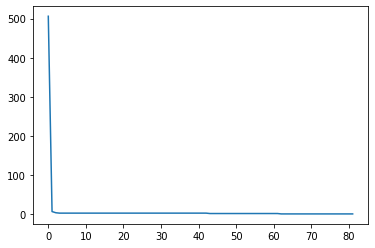

In [28]:
describe_components(investor_graph)

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 16.37%
投資家コンポーネント上位10件のサイズ
[417   3   2   1   1   1   1   1   1   1]
ネットワーク密度: 4.16%


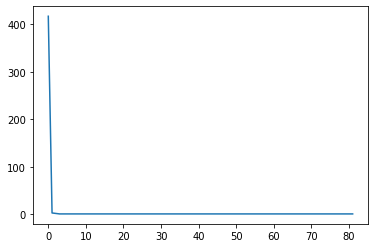

In [29]:
describe_components(company_graph)

## 企業 - 国・産業ネットワーク

In [30]:
country_industry_df = pd.merge(company_graph_pd, df[["Company", "Country", "Industry"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Industry"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()

,source,target,Country_source,Industry_source,Country_target,Industry_target
0,Payoneer,Marqeta,United States,Fintech,United States,Fintech
1,Payoneer,Mirakl,United States,Fintech,France,E-commerce & direct-to-consumer
2,Payoneer,Via Transportation,United States,Fintech,United States,Auto & transportation
3,Payoneer,HighRadius,United States,Fintech,United States,Fintech
4,Payoneer,Wacai,United States,Fintech,China,Mobile & telecommunications


In [31]:
country_graph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_graph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_graph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_graph.csv"))

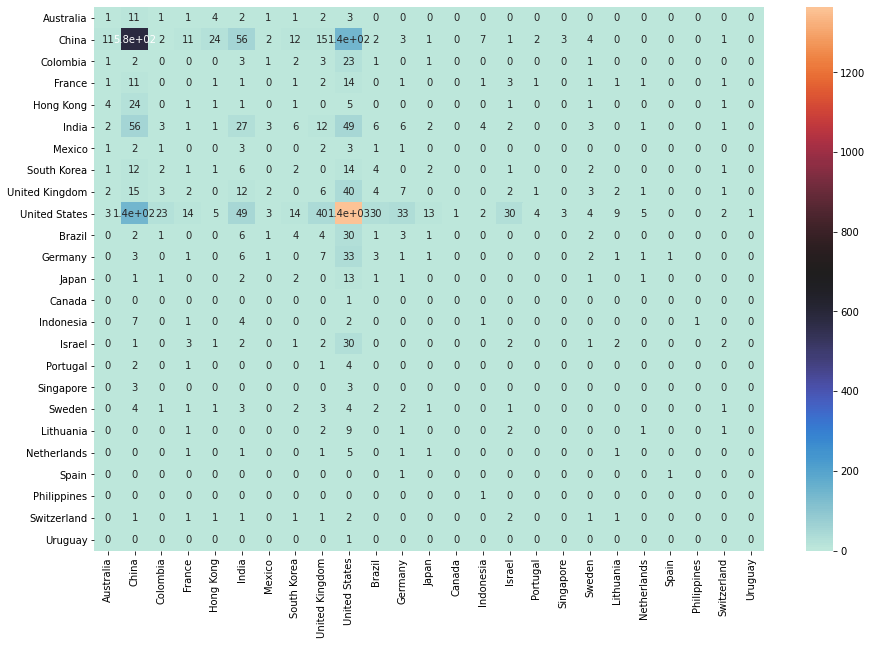

In [32]:
plt.figure(figsize=(15, 10))
sns.heatmap(country_graph_matrix, center=700, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "country_graph.png"))

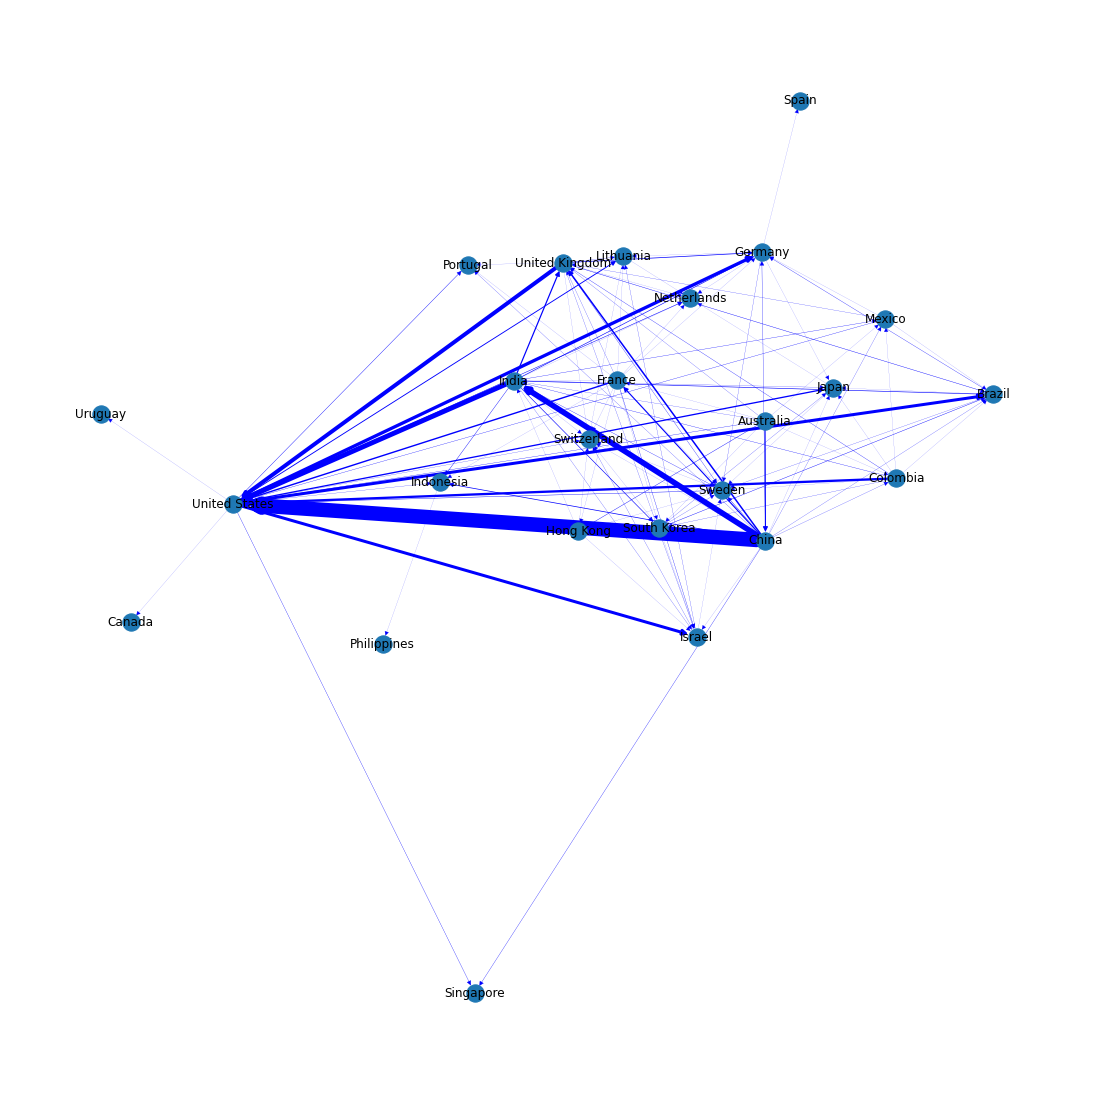

In [33]:
country_DG = nx.from_pandas_edgelist(
    country_graph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "country_dgraph.png"))
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "country_dgraph.csv"))

In [34]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
country_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_dgraph.csv"))

In [35]:
industry_graph_df = country_industry_df.groupby(by=["Industry_source", "Industry_target"], as_index=False).agg({"source": 'count'})
industry_graph_df.columns = ["source", "target", "weight"]
industry_graph_df.to_csv()
industry_G = nx.from_pandas_edgelist(industry_graph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,20
1,Artificial intelligence,Auto & transportation,12
2,Artificial intelligence,Consumer & retail,8
3,Artificial intelligence,Cybersecurity,8
4,Artificial intelligence,Data management & analytics,16


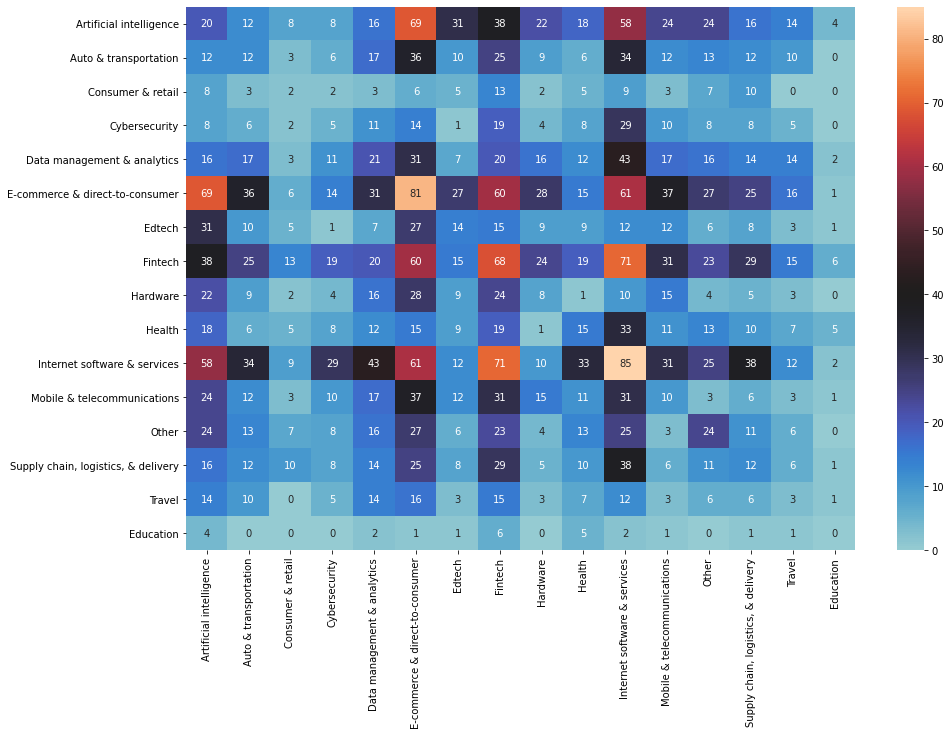

In [36]:
plt.figure(figsize=(15, 10))
sns.heatmap(industry_graph_matrix, center=40, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_graph.png"))

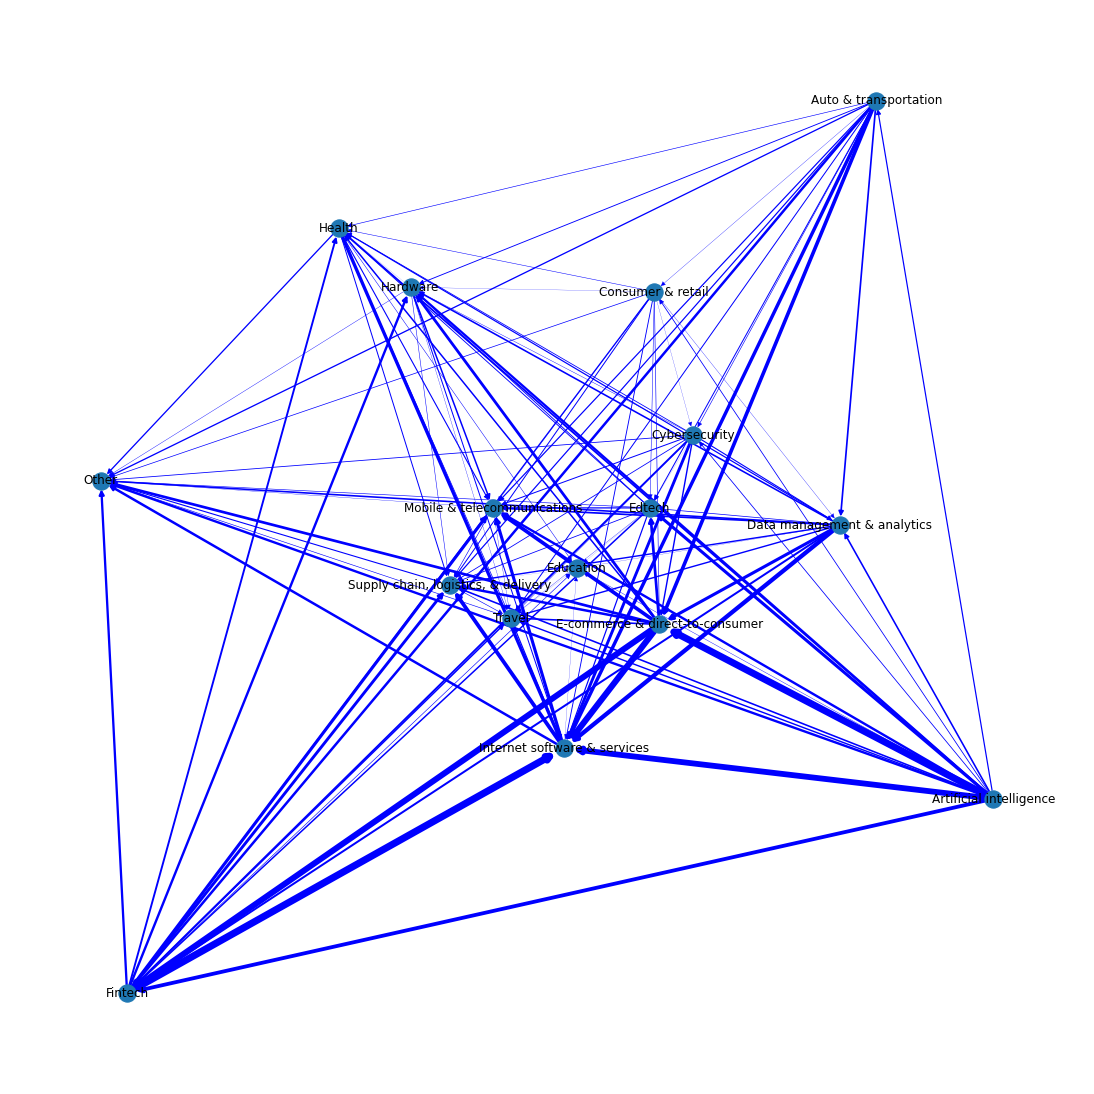

In [37]:
industry_DG = nx.from_pandas_edgelist(industry_graph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "industry_dgraph.png"))
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_dgraph.csv"))

In [38]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
industry_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_dgraph.csv"))

In [39]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [40]:
country_centrality_df.to_csv(os.path.join("..", "out", "features", "country_unicorn_centrality.csv"))

In [41]:
industry_centrality_df.to_csv(os.path.join("..", "out", "features", "industry_unicorn_centrality.csv"))

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [42]:
df.sort_values(by=["Date Joined"])

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
255,LinkSure Network,$1,1/1/2015,China,Mobile & telecommunications,[N/A],1.00,2015-01-01
242,Kuaishou,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.00,2015-01-01
244,L&P Cosmetic,$1.19,1/1/2016,South Korea,Consumer & retail,[CDIB Capital],1.19,2016-01-01
418,Traveloka,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.00,2017-01-01
24,AppLovin,$2,1/1/2017,United States,Mobile & telecommunications,"[Orient Hontai Capital, Webb Investment Network]",2.00,2017-01-01
...,...,...,...,...,...,...,...,...
275,Mia.com,$1,9/8/2015,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, ZhenFund, K2 Ventures]",1.00,2015-09-08
302,OfferUp,$1.20,9/8/2016,United States,Mobile & telecommunications,"[Andreessen Horowitz, GGV Capital, T. Rowe P...",1.20,2016-09-08
280,Mollie,$1,9/8/2020,Netherlands,Fintech,[Technology Crossover Ventures],1.00,2020-09-08
460,WEMAKEPRICE,$2.34,9/9/2015,South Korea,E-commerce & direct-to-consumer,"[IMM Investment, NXC]",2.34,2015-09-09


In [43]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [44]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,2.954321,717.90,1.0,46.00,243.0
China,4.379661,516.80,1.0,140.00,118.0
India,3.510400,87.76,1.0,16.00,25.0
United Kingdom,2.728750,65.49,1.0,11.08,24.0
South Korea,2.761818,30.38,1.0,9.00,11.0


In [45]:
industry_group = df.groupby("Industry").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Industry,,,,,
Fintech,3.513099,249.43,1.0,36.0,71.0
Artificial intelligence,5.386444,242.39,1.0,140.0,45.0
E-commerce & direct-to-consumer,2.683594,171.75,1.0,15.0,64.0
Auto & transportation,4.915357,137.63,1.0,62.0,28.0
Internet software & services,2.047656,131.05,1.0,6.0,64.0


In [46]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

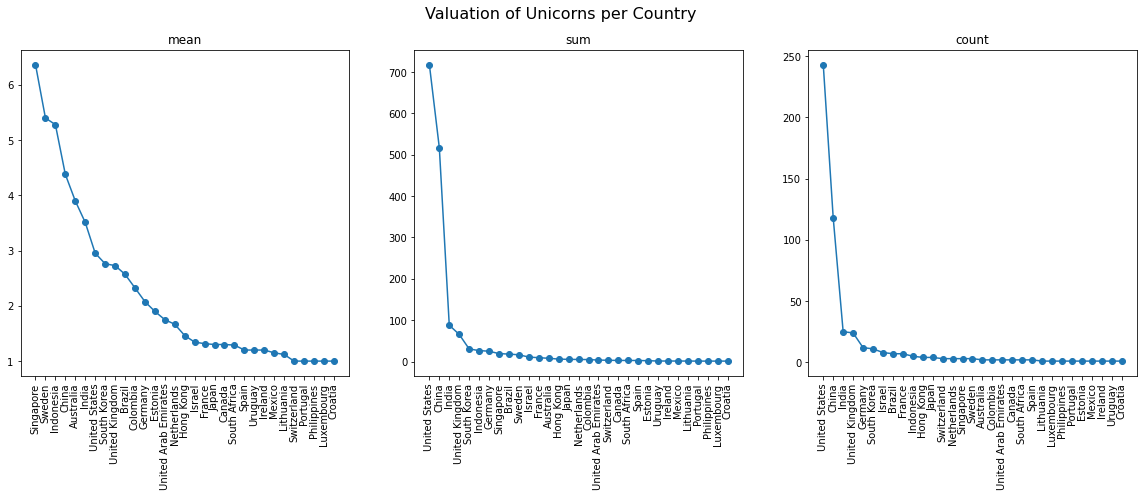

Complete output to ../out/features/value_per_country.png


In [47]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

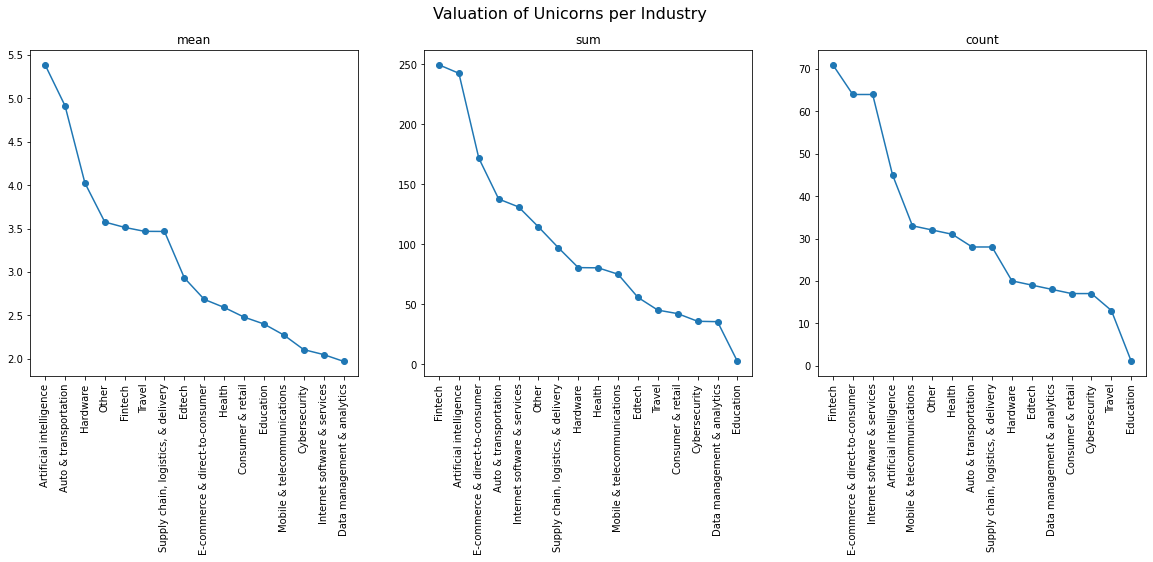

Complete output to ../out/features/value_per_industry.png


In [48]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [49]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

501


,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2018-04-18,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00
2018-03-07,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00
2015-07-03,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50
2018-12-19,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00
2015-10-12,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00
...,...,...,...,...,...,...,...
2015-04-10,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60
2018-11-01,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25
2018-07-18,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00


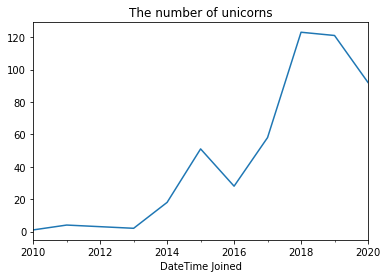

In [50]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join("..", "out", "features", "n_unicorns_time_change.png"))

# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [51]:
company_graph_pd

,source,target
0,Payoneer,Marqeta
1,Payoneer,Mirakl
2,Payoneer,Via Transportation
3,Payoneer,HighRadius
4,Payoneer,Wacai
...,...,...
3605,StockX,ServiceTitan
3606,StockX,23andMe
3607,Cambridge Mobile Telematics,Auto1 Group
3608,Robinhood,23andMe


In [52]:
uc_date = df[["Company", "Date Joined", "Country", "Industry", "Valuation($B) flaot"]]
datetime_s = uc_date["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
uc_date["DateTime Joined"] = datetime_s
uc_date = uc_date.set_index("Company")
elem_dict = uc_date.to_dict("index")

/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
uc_date.head()

,Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
Company,,,,,
100credit,4/18/2018,China,Fintech,1.0,2018-04-18
17zuoye,3/7/2018,China,Edtech,1.0,2018-03-07
23andMe,7/3/2015,United States,Health,2.5,2015-07-03
4Paradigm,12/19/2018,China,Artificial intelligence,2.0,2018-12-19
58 Daojia,10/12/2015,China,Internet software & services,1.0,2015-10-12


In [54]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Payoneer,Marqeta
1,Payoneer,Mirakl
2,Payoneer,Via Transportation
3,Payoneer,HighRadius
4,Payoneer,Wacai
...,...,...
3605,ServiceTitan,StockX
3606,23andMe,StockX
3607,Auto1 Group,Cambridge Mobile Telematics
3608,23andMe,Robinhood


In [55]:
# チェック用
print(elem_dict["Flexport"]["Date Joined"])
print(elem_dict["Knotel"]["Date Joined"])
print(elem_dict["Gong"]["Date Joined"])
print(elem_dict["VAST Data"]["Date Joined"])
print(elem_dict["Dave"]["Date Joined"])
print(elem_dict["Udemy"]["Date Joined"])

4/30/2018
8/21/2019
8/12/2020
4/16/2020
9/30/2019
2/19/2020


In [56]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [57]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Industry"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Industry"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [58]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [59]:
val_size[:10]

[100.0,
 121.36690647482014,
 103.23741007194245,
 108.09352517985612,
 100.0,
 100.0,
 109.71223021582733,
 103.23741007194245,
 118.77697841726618,
 112.94964028776978]

In [60]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join("..", "out", "sen2jun_dgraph"))

In [61]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [62]:
comp_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [63]:
investor_graph_pd

,source,target
0,JOY Capital,Capital Today
1,JOY Capital,Morningside Ventures
2,Index Ventures,Google Ventures
3,Index Ventures,Benchmark
4,Index Ventures,Airbus Ventures
...,...,...
1235,Core Capital Partners,Battery Ventures
1236,Steadview Capital,Kaalari Capital
1237,Tokopedia_,Grab_
1238,Lakestar,Battery Ventures


In [64]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [65]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,JOY Capital,Capital Today
1,JOY Capital,Morningside Ventures
2,Google Ventures,Index Ventures
3,Index Ventures,Benchmark
4,Index Ventures,Airbus Ventures
...,...,...
1235,Battery Ventures,Core Capital Partners
1236,Steadview Capital,Kaalari Capital
1237,Tokopedia_,Grab_
1238,Battery Ventures,Lakestar


In [66]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [67]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,JOY Capital,0.002967,0.000000,8.626761e-47,0.000000,0.000863,0.000000,0.002967,3,6,...,1.50,1,1.500000,1,{China},1,{Travel},1,{XiaoZhu},2017-11-01
1,Capital Today,0.005935,0.000051,6.076872e-12,0.017092,0.001493,0.004451,0.001484,3,5,...,3.50,2,1.750000,1,{China},1,{Travel},2,"{Mafengwo, XiaoZhu}",2017-11-01
2,Morningside Ventures,0.008902,0.000167,1.616618e-10,0.019937,0.002587,0.004451,0.004451,2,4,...,7.50,3,2.500000,1,{China},2,"{Travel, E-commerce & direct-to-consumer}",3,"{Aihuishou, SouChe Holdings, XiaoZhu}",2017-11-01
3,Google Ventures,0.038576,0.003315,2.097964e-13,0.030872,0.002683,0.014837,0.023739,5,132,...,40.50,15,2.700000,1,{United States},8,"{Internet software & services, Health, Other, ...",15,"{StockX, Dialpad, KeepTruckin, Podium, Robinho...",2015-07-03
4,Index Ventures,0.031157,0.003459,5.867076e-12,0.031881,0.002421,0.016320,0.014837,5,100,...,26.63,12,2.219167,3,"{France, United Kingdom, United States}",5,"{Artificial intelligence, Internet software & ...",12,"{Patreon, Roblox, BlaBlaCar, Aurora, KeepTruck...",2015-09-16


In [68]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [69]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.805104,-0.027757,0.208667,0.204940,0.657048,0.955085,0.523453,0.535531,NaN,NaN,1.000000,NaN,0.710327,0.989324,0.055185,0.762981,0.954295,0.989324
Betweenness Centrality,0.805104,1.000000,-0.020230,0.196147,0.255360,0.602643,0.739991,0.416447,0.405828,NaN,NaN,0.805104,NaN,0.637588,0.803229,0.042030,0.551859,0.713911,0.803229
Eigen Centrality,-0.027757,-0.020230,1.000000,0.108077,0.210350,0.008773,-0.037128,-0.055172,-0.029235,NaN,NaN,-0.027757,NaN,-0.024449,-0.028377,-0.016757,-0.026488,-0.032525,-0.028377
Closeness Centrality,0.208667,0.196147,0.108077,1.000000,0.361917,0.569132,0.029468,-0.125357,-0.163091,NaN,NaN,0.208667,NaN,0.071882,0.184966,-0.009131,0.159058,0.178994,0.184966
Page Rank,0.204940,0.255360,0.210350,0.361917,1.000000,0.564308,0.026843,-0.182418,-0.090323,NaN,NaN,0.204940,NaN,0.122610,0.188785,-0.014331,0.114990,0.165202,0.188785
In-degree Centrality,0.657048,0.602643,0.008773,0.569132,0.564308,1.000000,0.404147,0.134094,0.085489,NaN,NaN,0.657048,NaN,0.400355,0.632750,0.059547,0.492329,0.606554,0.632750
Out-degree Centrality,0.955085,0.739991,-0.037128,0.029468,0.026843,0.404147,1.000000,0.582428,0.616190,NaN,NaN,0.955085,NaN,0.704509,0.951682,0.043552,0.732244,0.919476,0.951682
Elongation,0.523453,0.416447,-0.055172,-0.125357,-0.182418,0.134094,0.582428,1.000000,0.821247,NaN,NaN,0.523453,NaN,0.402209,0.517931,0.112868,0.429726,0.558662,0.517931
Expansion,0.535531,0.405828,-0.029235,-0.163091,-0.090323,0.085489,0.616190,0.821247,1.000000,NaN,NaN,0.535531,NaN,0.487470,0.535260,0.159295,0.401460,0.554788,0.535260
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


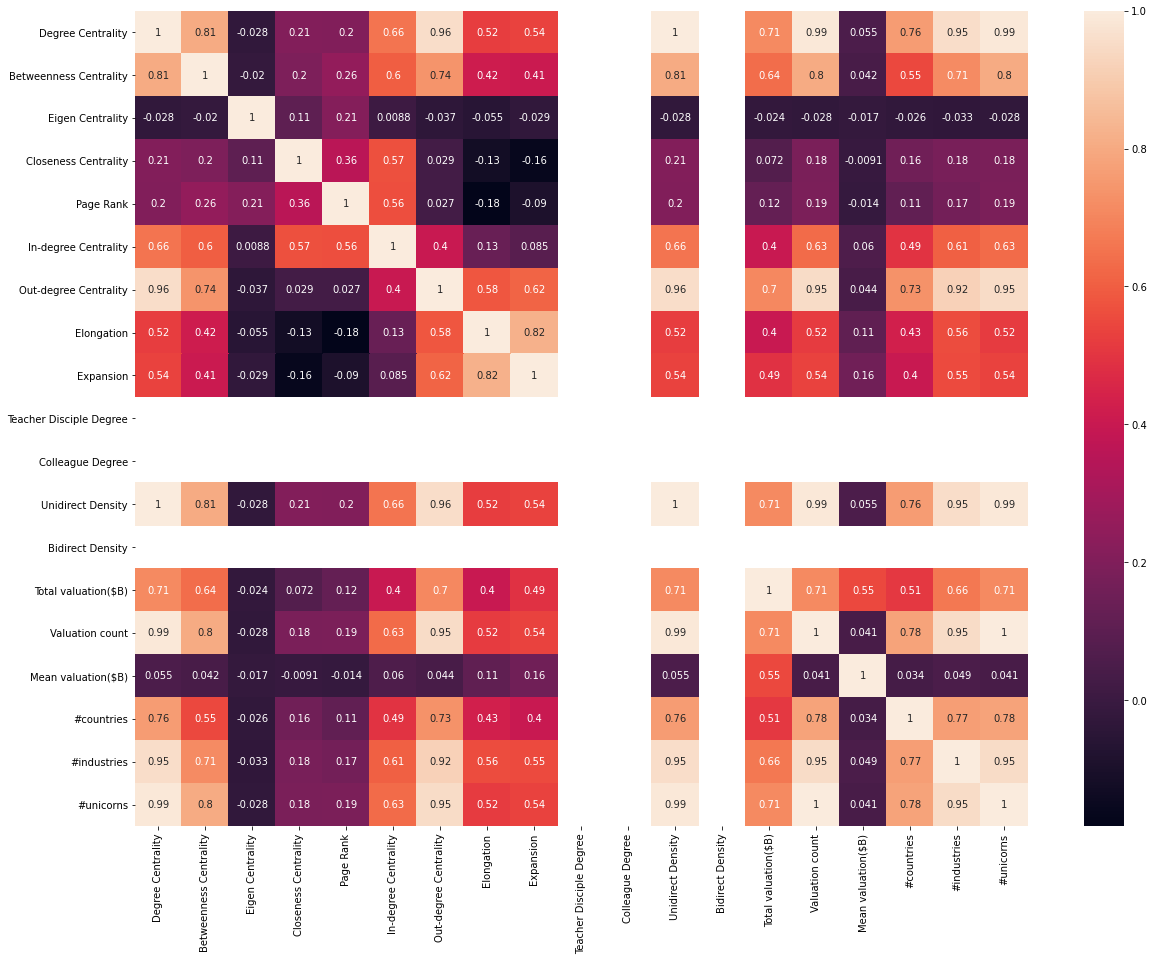

In [70]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "investor_correlation.png"))

In [71]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,100credit,1.0
1,17zuoye,1.0
2,23andMe,2.5
3,4Paradigm,2.0
4,58 Daojia,1.0


In [72]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [73]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Payoneer,0.014252,0.000000,2.538946e-59,0.000000,0.000815,0.000000,0.014252,9,129,1.0,...,0.007109,0.0,$1,12/5/2017,United States,Fintech,"[Susquehanna Growth Equity, 83North, China B...",1.00,2017-12-05,1.00
Marqeta,0.009501,0.000000,6.754653e-29,0.050908,0.000984,0.004751,0.004751,3,4,1.0,...,0.004739,0.0,$4.30,5/21/2019,United States,Fintech,"[83North, Granite Ventures, CommerzVentures]",4.30,2019-05-21,4.30
Mirakl,0.009501,0.000000,1.708557e-08,0.081035,0.002984,0.009501,0.000000,0,0,1.0,...,0.004739,0.0,$1.50,9/22/2020,France,E-commerce & direct-to-consumer,"[Elaia Partners, 83North, Felix Capital]",1.50,2020-09-22,1.50
Via Transportation,0.019002,0.001824,1.789286e-09,0.087438,0.003722,0.014252,0.004751,2,3,1.0,...,0.009479,0.0,$2.25,3/30/2020,United States,Auto & transportation,"[83North, RiverPark Ventures, Pitango Ventur...",2.25,2020-03-30,2.25
HighRadius,0.014252,0.000000,1.837125e-21,0.116490,0.004695,0.014252,0.000000,0,0,1.0,...,0.007109,0.0,$1,1/7/2020,United States,Fintech,"[Susquehanna Growth Equity, Citi Ventures, I...",1.00,2020-01-07,1.00


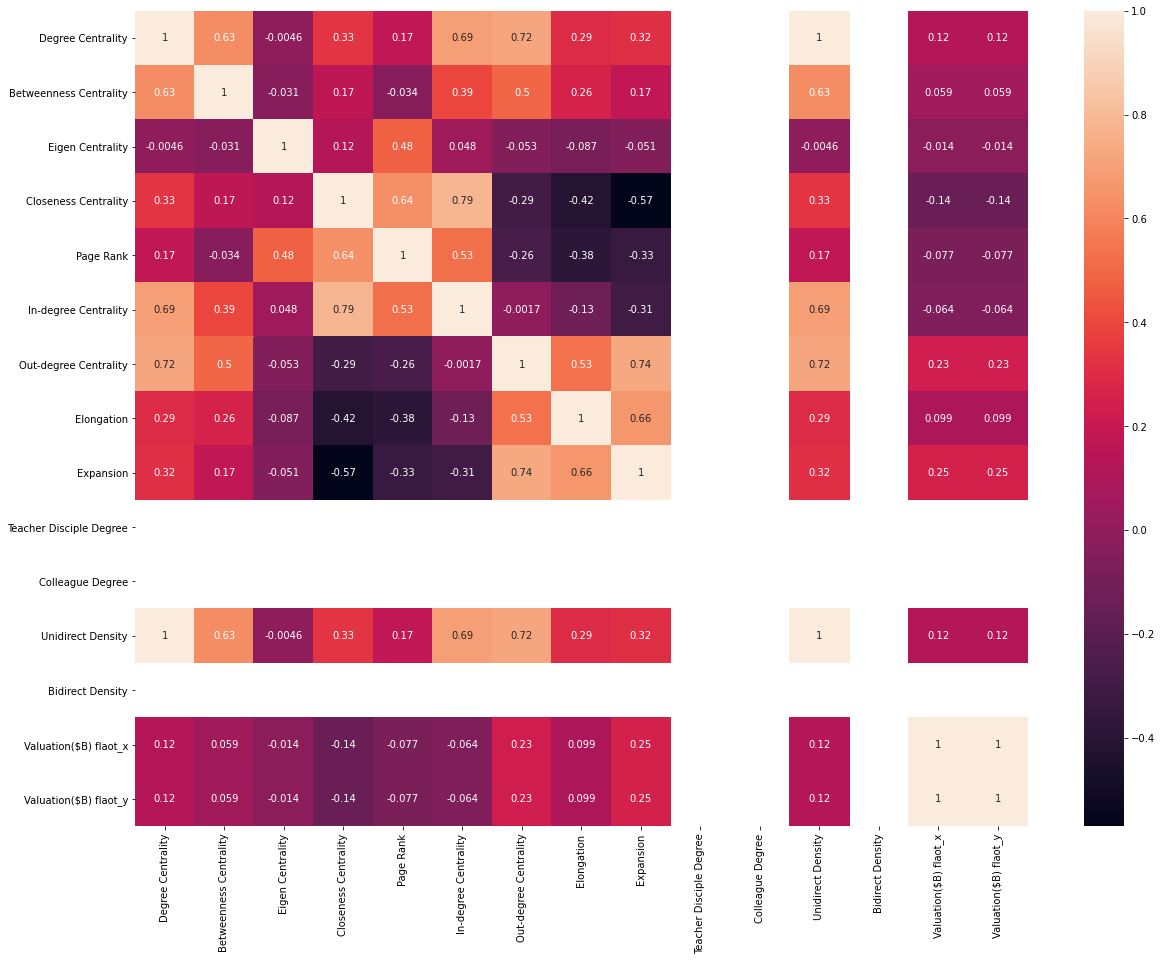

In [74]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

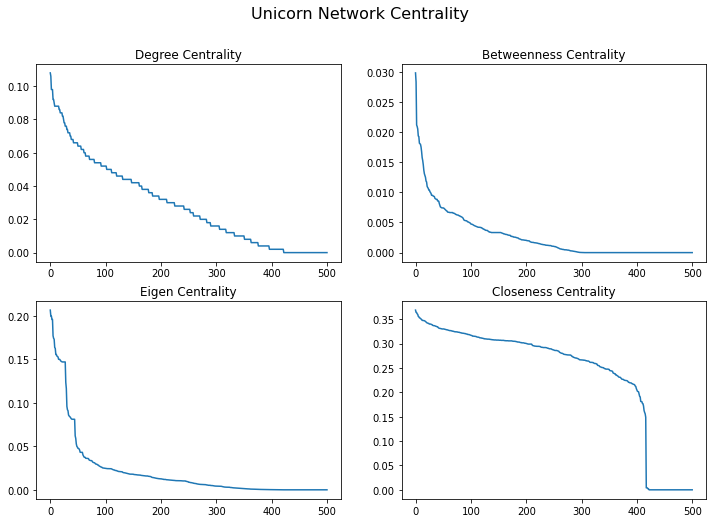

In [75]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "unicorn_network_centrality.png"))

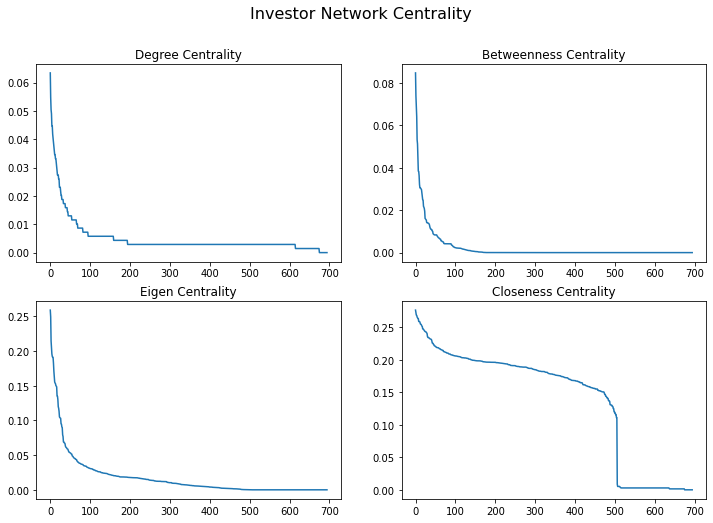

In [76]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "investor_network_centrality.png"))

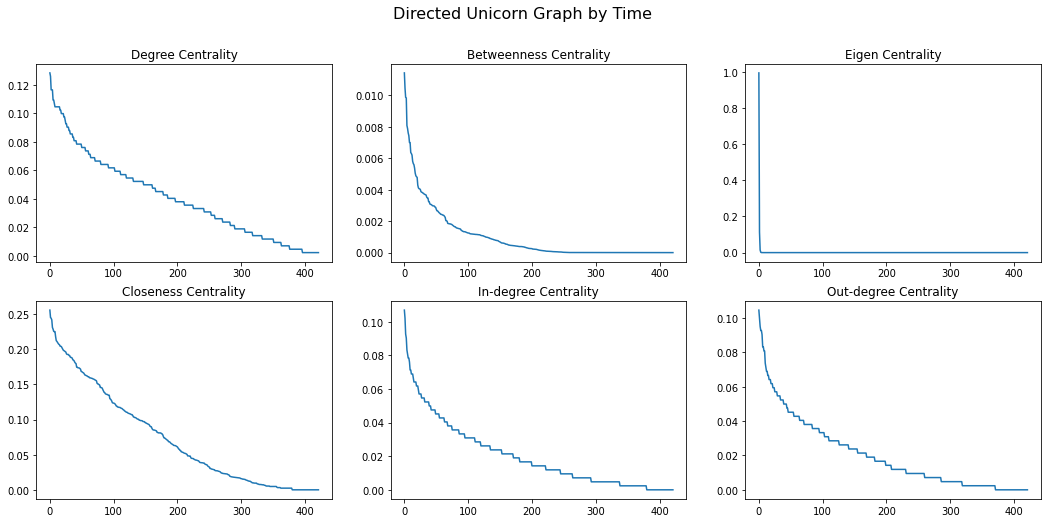

In [77]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "directed_unicorn_centrality.png"))

# データの出力

In [78]:
investor_centrality_df.to_csv(os.path.join("..", "out", "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join("..", "out", "features", "unicorn_centrality.csv"))

In [79]:
unicorn_data_df.corr().to_csv(os.path.join("..", "out", "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join("..", "out", "features", "investor_correlation.csv"))

# 回帰分析

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [81]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Payoneer,0.014252,0.000000,2.538946e-59,0.000000,0.000815,0.000000,0.014252,9,129,1.0,...,0.007109,0.0,$1,12/5/2017,United States,Fintech,"[Susquehanna Growth Equity, 83North, China B...",1.00,2017-12-05,1.00
Marqeta,0.009501,0.000000,6.754653e-29,0.050908,0.000984,0.004751,0.004751,3,4,1.0,...,0.004739,0.0,$4.30,5/21/2019,United States,Fintech,"[83North, Granite Ventures, CommerzVentures]",4.30,2019-05-21,4.30
Mirakl,0.009501,0.000000,1.708557e-08,0.081035,0.002984,0.009501,0.000000,0,0,1.0,...,0.004739,0.0,$1.50,9/22/2020,France,E-commerce & direct-to-consumer,"[Elaia Partners, 83North, Felix Capital]",1.50,2020-09-22,1.50
Via Transportation,0.019002,0.001824,1.789286e-09,0.087438,0.003722,0.014252,0.004751,2,3,1.0,...,0.009479,0.0,$2.25,3/30/2020,United States,Auto & transportation,"[83North, RiverPark Ventures, Pitango Ventur...",2.25,2020-03-30,2.25
HighRadius,0.014252,0.000000,1.837125e-21,0.116490,0.004695,0.014252,0.000000,0,0,1.0,...,0.007109,0.0,$1,1/7/2020,United States,Fintech,"[Susquehanna Growth Equity, Citi Ventures, I...",1.00,2020-01-07,1.00


In [82]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation($B)', 'Date Joined', 'Country',
       'Industry', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [83]:
train_df = unicorn_data_df.drop([
    'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Company,,,
Payoneer,0.014252,129,1.00
Marqeta,0.004751,4,4.30
Mirakl,0.000000,0,1.50
Via Transportation,0.004751,3,2.25
HighRadius,0.000000,0,1.00


<AxesSubplot:>

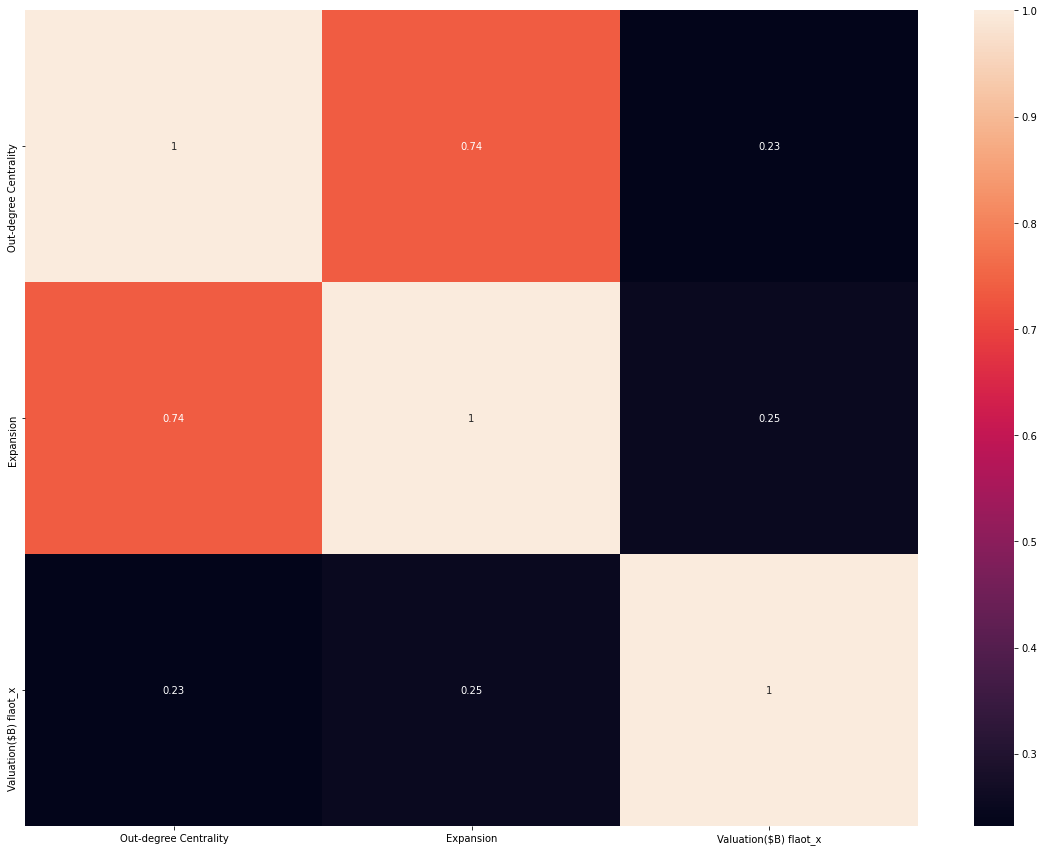

In [84]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [85]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [86]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Valuation($B) flaot_x   R-squared:                       0.068
Model:                               OLS   Adj. R-squared:                  0.064
Method:                    Least Squares   F-statistic:                     15.33
Date:                   Fri, 16 Apr 2021   Prob (F-statistic):           3.74e-07
Time:                           20:25:00   Log-Likelihood:                -583.89
No. Observations:                    422   AIC:                             1174.
Df Residuals:                        419   BIC:                             1186.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9.964e-17      0.047  -2.11e-15      1.000      -0.093       0.093
Out-degree Centrality     0.1016      0.070      1.458      0.146      -0.035       0.239
Expansion                 0.1772      0.070      2.543      0.011       0.040       0.314
==============================================================================
Omnibus:                      792.635   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           599315.902
Skew:                          12.003   Prob(JB):                         0.00
Kurtosis:                     186.052   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
train_df.corr()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Out-degree Centrality,1.000000,0.736192,0.231998
Expansion,0.736192,1.000000,0.251942
Valuation($B) flaot_x,0.231998,0.251942,1.000000


In [88]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

Out-degree Centrality    0.0
Expansion                0.0
dtype: float64

In [89]:
with open(os.path.join("..", "out", "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [90]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,JOY Capital,0.002967,0.000000,8.626761e-47,0.000000,0.000863,0.000000,0.002967,3,6,1.0,0.0,0.001481,0.0,1.50,1,1.500000,1,1,1
1,Capital Today,0.005935,0.000051,6.076872e-12,0.017092,0.001493,0.004451,0.001484,3,5,1.0,0.0,0.002963,0.0,3.50,2,1.750000,1,1,2
2,Morningside Ventures,0.008902,0.000167,1.616618e-10,0.019937,0.002587,0.004451,0.004451,2,4,1.0,0.0,0.004444,0.0,7.50,3,2.500000,1,2,3
3,Google Ventures,0.038576,0.003315,2.097964e-13,0.030872,0.002683,0.014837,0.023739,5,132,1.0,0.0,0.019259,0.0,40.50,15,2.700000,1,8,15
4,Index Ventures,0.031157,0.003459,5.867076e-12,0.031881,0.002421,0.016320,0.014837,5,100,1.0,0.0,0.015556,0.0,26.63,12,2.219167,3,5,12


In [91]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,675.000000,675.000000,6.750000e+02,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.0,675.0,675.000000,675.0,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.005451,0.000163,3.258097e-03,0.012795,0.001481,0.002726,0.002726,1.491852,29.017778,1.0,0.0,0.002722,0.0,6.851896,2.022222,2.959295,1.257778,1.644444,2.022222
std,0.007363,0.000671,3.838032e-02,0.012020,0.000607,0.002385,0.006068,2.223661,84.233477,0.0,0.0,0.003676,0.0,18.237397,2.981811,7.060772,0.823565,1.617168,2.981811
min,0.001484,0.000000,8.626761e-47,0.000000,0.000863,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000741,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.002967,0.000000,4.701585e-44,0.001484,0.000986,0.001484,0.000000,0.000000,0.000000,1.0,0.0,0.001481,0.0,1.085000,1.000000,1.037500,1.000000,1.000000,1.000000
50%,0.002967,0.000000,2.615632e-24,0.009810,0.001268,0.002967,0.001484,1.000000,1.000000,1.0,0.0,0.001481,0.0,2.000000,1.000000,1.600000,1.000000,1.000000,1.000000
75%,0.004451,0.000000,1.215729e-11,0.022247,0.001779,0.002967,0.002967,1.000000,2.000000,1.0,0.0,0.002222,0.0,4.450000,2.000000,2.666667,1.000000,2.000000,2.000000
max,0.065282,0.010286,5.494310e-01,0.053368,0.004305,0.019288,0.053412,10.000000,444.000000,1.0,0.0,0.032593,0.0,225.280000,28.000000,140.000000,9.000000,13.000000,28.000000


In [92]:
investor_data_df = investor_data_df.set_index("Investor")

In [93]:
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,675.000000,675.000000,675.000000,675.000000
mean,0.000163,29.017778,2.022222,6.851896
std,0.000671,84.233477,2.981811,18.237397
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.085000
50%,0.000000,1.000000,1.000000,2.000000
75%,0.000000,2.000000,2.000000,4.450000
max,0.010286,444.000000,28.000000,225.280000


In [94]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [95]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total valuation($B)   R-squared:                       0.536
Model:                             OLS   Adj. R-squared:                  0.534
Method:                  Least Squares   F-statistic:                     258.3
Date:                 Fri, 16 Apr 2021   Prob (F-statistic):          2.15e-111
Time:                         20:25:00   Log-Likelihood:                -698.71
No. Observations:                  675   AIC:                             1405.
Df Residuals:                      671   BIC:                             1423.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   5.421e-18      0.026   2.06e-16      1.000      -0.052       0.052
Betweenness Centrality     0.1969      0.044      4.454      0.000       0.110       0.284
Expansion                  0.1561      0.031      5.008      0.000       0.095       0.217
#unicorns                  0.4698      0.048      9.823      0.000       0.376       0.564
==============================================================================
Omnibus:                      950.099   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           204218.891
Skew:                           7.552   Prob(JB):                         0.00
Kurtosis:                      86.863   Cond. No.                         3.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [97]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

Betweenness Centrality    0.0
Expansion                 0.0
#unicorns                 0.0
dtype: float64

In [98]:
with open(os.path.join("..", "out", "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())